# **Projet Télédétection Landes - Marion BILLY**

## I - Introduction

Série temporelle Sentinel-2 utilisée: Bretagne 24-25   
- 2025-03-31     
- 2025-04-10	  
- 2025-05-15	  
- 2025-06-17	  
- 2025-07-12	  
- 2025-08-10

Echantillon: PI_strates_bretagne.shp   
Champ strate qui contient les labels numériques des classes:   
- 1	Sol Nu    
- 2	Herbe    
- 3	Landes    
- 4	Arbre  

In [2]:
# import des librairies
import sys
sys.path.append("/home/onyxia/work")
import pandas as pd
import geopandas as gpd
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# personal librairies
from libsigma import read_and_write as rw
from libsigma import classification as cla

Extraction des séries temporelles par bande Sentinel, chaque bande d’un fichier correspondant à une date (même ordre que ci-dessus)

Les images Sentinel-2 sont initialement fournies sous forme de séries temporelles par bande. Afin de faciliter les analyses ultérieures, les bandes ont été regroupées par date pour produire une image multibande Sentinel-2 par date.

In [2]:
base_path = "/home/onyxia/work/data/projet_eval/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)  # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(base_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(base_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


## II - Analyse des échantillons

### 1. Nombre d'échantillons

In [11]:
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
gdf.head()

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


#### Diagramme en bâton du nombre de polygones par classe, diag_baton_nb_poly_by_class.png

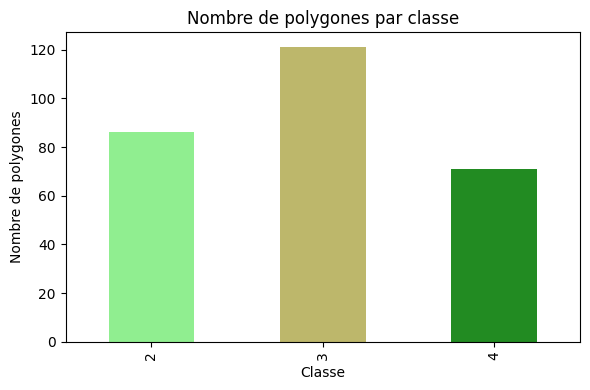

In [26]:
nb_poly = gdf["strate"].value_counts().sort_index()
plt.figure(figsize=(6,4))
colors = ["lightgreen", "darkkhaki", "forestgreen"]
nb_poly.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png", dpi=300)
plt.show()

#### Diagramme en bâton du nombre de pixel par classe, diag_baton_nb_pix_by_class.png

Créer une image d’échantillons en rasterisant le fichier vecteur. L’image créée aura les mêmes dimensions que l’image qu’on cherche à classer ainsi que la même taille de pixel. Une fois cette image obtenue, il est facile d’extraire les valeurs des pixels de l’image qui correspondent aux échantillons à l’aide de Numpy.

Les paramètres spatiaux (résolution et emprise) sont extraits de l’image Sentinel-2 de référence afin de garantir une parfaite correspondance spatiale entre l’image d’échantillons rasterisée et les images utilisées pour la classification.

In [5]:
my_folder = '/home/onyxia/work/data/projet_eval'
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence

# ouverture de l'image
data_set = rw.open_image(ref_image)

# informations de l'image
nb_lignes, nb_col, _ = rw.get_image_dimension(data_set)
origin_x, origin_y = rw.get_origin_coordinates(data_set)
psize_x, psize_y = rw.get_pixel_size(data_set)
sptial_resolution = abs(psize_x)

# emprise spatiale
xmin = origin_x
xmax = origin_x + nb_col * psize_x
ymax = origin_y
ymin = origin_y + nb_lignes * psize_y

# affichage des paramètres
print("Spatial resolution :", sptial_resolution)
print("Extent :")
print("xmin =", xmin, "ymin =", ymin)
print("xmax =", xmax, "ymax =", ymax)

Spatial resolution : 10.0
Extent :
xmin = 432950.0 ymin = 5362770.0
xmax = 448280.0 ymax = 5368890.0


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
# define parameters
my_folder = '/home/onyxia/work/data/projet_eval'
in_vector = os.path.join(my_folder, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.splitext(in_vector)[0] + '_v2.tif'
field_name = 'strate'  # field containing the numeric label of the classes

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

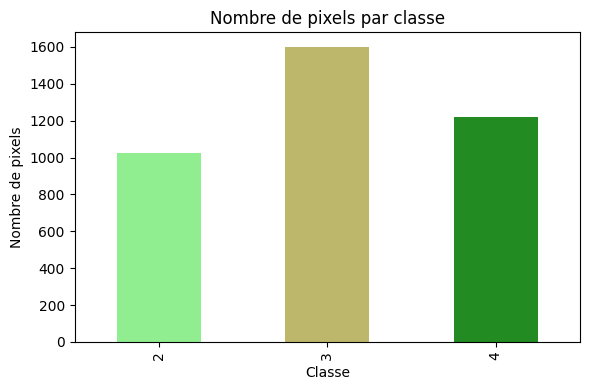

In [28]:
roi_raster = os.path.join(my_folder, 'PI_strates_bretagne_32630_v2.tif')

# get_samples_from_roi renvoie X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
pixel_counts = dict(zip(classes, counts))

# tri par classe
pixel_series = pd.Series(pixel_counts).sort_index()

# Diagramme
plt.figure(figsize=(6,4))
colors = ["lightgreen", "darkkhaki", "forestgreen"]
pixel_series.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png", dpi=300)
plt.show()

### 2. Phénologie des strates, mise en évidence des landes

Reconnaître les signatures spectrales et leur évolution temporelle.

On a la liste des images multibandes par date. (B03 → index 1, B05 → index 3)

Calcul ARI

In [30]:
# dossier de travail
data_dir = "/home/onyxia/work/data/projet_eval"
out_dir = "/home/onyxia/work/results"

dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

ari_list = []

for date in dates:
    filename = os.path.join(data_dir, f"bretagne_{date}.tif")

    # ouverture
    data_set = rw.open_image(filename)
    img = rw.load_img_as_array(filename)

    # bandes nécessaires
    b03 = img[:, :, 1].astype("float32")
    b05 = img[:, :, 3].astype("float32")

    # éviter divisions par zéro
    mask = (b03 > 0) & (b05 > 0)

    ari = np.full(b03.shape, -9999, dtype="float32")

    ari[mask] = (
        (1.0 / b03[mask] - 1.0 / b05[mask]) /
        (1.0 / b03[mask] + 1.0 / b05[mask])
    )

    ari_list.append(ari[:, :, np.newaxis])



Empilement temporel

In [33]:
ari_serie_temp = np.concatenate(ari_list, axis=2)

out_filename = os.path.join(out_dir, "ARI_serie_temp.tif")

rw.write_image(
    out_filename,
    ari_serie_temp,
    data_set=data_set,
    gdal_dtype=gdal.GDT_Float32,
)

### 3. Production d’une d’essence forestière à l’échelle du pixel